# Pipeline
 
This is a complete pipeline for extracting events, matching them across loggers and outputting position estimates. Simply set up the world parameters, point to a directory and it will process and analyze everything needed.

* Here we process all the data from the buffalo kill dataset. This consists of a surveyed (ground-truth) final kill location, and audio data from 4 loggers. We use this data to validate the pipeline.

* UPDATE: APRIL 2019: This script has been modified to use the coherence detector to find events in the source file

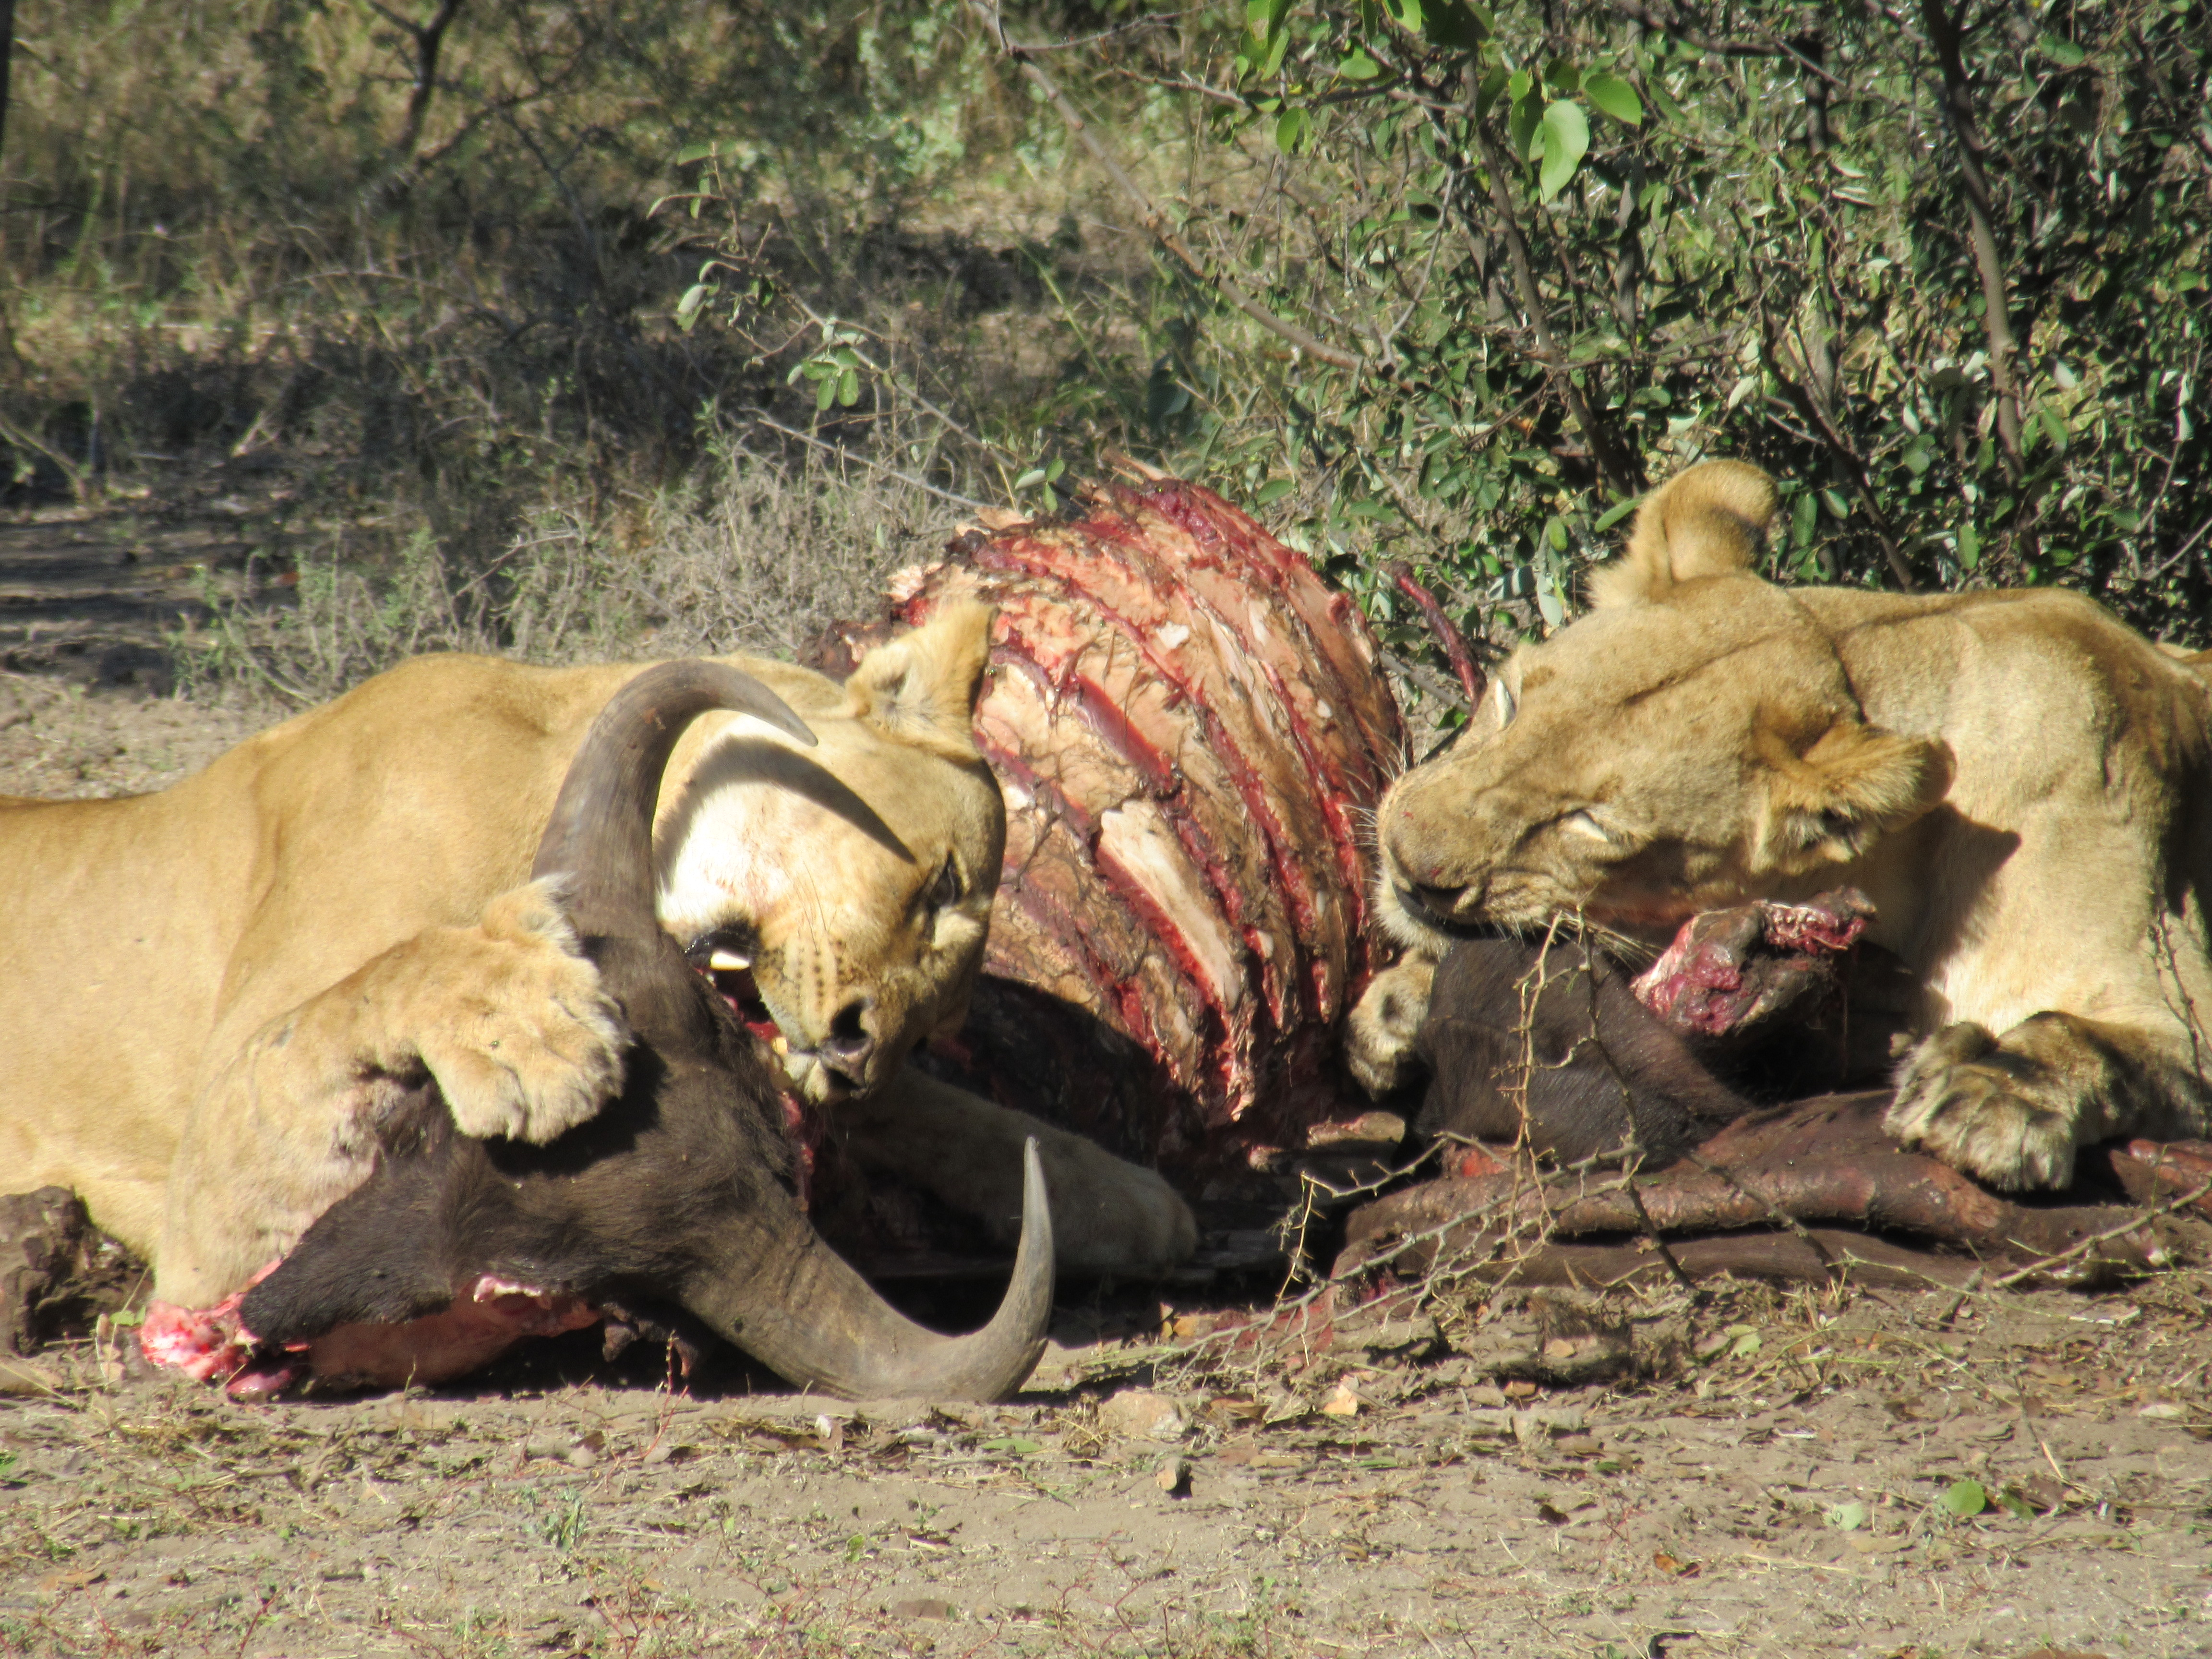

In [1]:
# We use this magic to force modules to reload everytime we run the script. This allows us to make changes to the module library
%load_ext autoreload
%autoreload 2
# Because the notebooks are in a different directory to the shumba library, we use a bit of magic to append the module path
# to the python path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Libraries
Import all the libraries that we need

In [2]:
# we can now include the libraries we need
from shumba import shumbacore
from shumba import audiocore
from shumba import extract
from shumba import match
from shumba import position

### World
Here we set up the world and the loggers, define the area (extent) that we are interested in and the file timestamps which we want to process

In [3]:
# we create our logger objects and embed them into our world. 
# the size of our world. note that the origin (0,0) is defined by
# the position of the lower left node
worldExtents = [-1500,3000,-1500,3000] 
world = shumbacore.World(worldExtents,sample_rate=44100)
coarse_timestamps = [1528419100,1528419200,1528419300,1528419400,1528419500]
# Where the files live
logger_directory = "..\\..\\DeploymentData\\BuffaloKillResampled\\"
logger_filepattern =  "{:02d}\hq_{:d}.wav"
# Coordinates of the loggers
logger7pos = shumbacore.Position(-21.7278,29.8843,'LatLong')
logger8pos = shumbacore.Position(-21.7237,29.8819,'LatLong')
logger10pos = shumbacore.Position(-21.7317,29.8876,'LatLong')
logger14pos = shumbacore.Position(-21.7359,29.8777,'LatLong')
# Setup the loggers themselves
logger7 = shumbacore.Logger(id=7,name=7,position=logger7pos,directory=logger_directory,filetemplate=logger_filepattern)
logger8 = shumbacore.Logger(id=8,name=8,position=logger8pos,directory=logger_directory,filetemplate=logger_filepattern)
logger10 = shumbacore.Logger(id=10,name=10,position=logger10pos,directory=logger_directory,filetemplate=logger_filepattern)
logger14 = shumbacore.Logger(id=14,name=14,position=logger14pos,directory=logger_directory,filetemplate=logger_filepattern)
loggerlist = [logger7,logger8,logger10,logger14]
# Add the loggers to the world
for logger in loggerlist:
    world.addLogger(logger)

### Ground-truth kill site

This was surveyed as the final location of the buffalo carcass. It provides a single point of reference which we can use to validate the acoustic scene.

In [4]:
lat = -21.7278
lon = 29.8797
targetpos = shumbacore.Position(lat,lon,'LatLong')
target = shumbacore.Target(0,"KillLoc",targetpos)
world.addTarget(target)

### Event segmentation
This loads up all the individual files and tries to extract events from them depending on the coherence score between the individual microphones. As a side effect, it also outputs a beamformed file. Although this code appears verbatim here, it also has been moved to the Shumba library as well.

In [5]:
import scipy
import numpy
def coherenceDetector(snippet_quad,window_size=512):
    """The window_size parameter here controls the PSD resolution"""
    f,Cxy = scipy.signal.coherence(snippet_quad[:,0],snippet_quad[:,1],fs=44100,nperseg=window_size)
    pk01 = numpy.max(Cxy)
    f,Cxy = scipy.signal.coherence(snippet_quad[:,0],snippet_quad[:,2],fs=44100,nperseg=window_size)
    pk02 = numpy.max(Cxy)
    f,Cxy = scipy.signal.coherence(snippet_quad[:,0],snippet_quad[:,3],fs=44100,nperseg=window_size)
    pk03 = numpy.max(Cxy)
    f,Cxy = scipy.signal.coherence(snippet_quad[:,1],snippet_quad[:,2],fs=44100,nperseg=window_size)
    pk12 = numpy.max(Cxy)
    f,Cxy = scipy.signal.coherence(snippet_quad[:,1],snippet_quad[:,3],fs=44100,nperseg=window_size)
    pk13 = numpy.max(Cxy)
    f,Cxy = scipy.signal.coherence(snippet_quad[:,2],snippet_quad[:,3],fs=44100,nperseg=window_size)
    pk23 = numpy.max(Cxy)
    metric = pk01+pk02+pk03+pk12+pk13+pk23
    return metric

# import Event out of the extract file
from shumba.extract import Event 
class CoherentEventSegmenter():

    """This class uses the coherence metric (rather than beamforming) to extract 
    events"""
    
    def __init__(self,window=4096,coherence_threshold=5.0,merge=25,event_length=5.0,Fs=44100):
        self.window = window
        self.coherence_threshold = coherence_threshold
        self.merge = merge
        self.event_length = event_length
        self.Fs = Fs
    
    def createMask(self,audio):
        # turn window snippets into True/False labels
        # the merge parameter simply stops repeated events happening within 
        # a certain period, to stop repeated triggering
        merge_counter = 0
        mask = []
        for k in range(0,len(audio),self.window):
            snippet = audio[k:k+self.window,:]
            metric = coherenceDetector(snippet)
            if (metric > self.coherence_threshold):
                if (merge_counter < 1):
                    mask.append(True)
                    merge_counter = self.merge
                else:
                    mask.append(False)
            else:
                mask.append(False)
            merge_counter-=1
        return mask

    def maskToEvents(self,logger,coarse_timestamp,mask,beamformed,corr,lags):
        eventList = []
        sampleidx = 0
        for m,c,l in zip(mask,corr,lags):
            if m is True:
                e = Event(logger,coarse_timestamp,
                    event_time = float(sampleidx)/self.Fs,
                    event_length=self.event_length)
                e.addAoA(c,l)
                # calculate signal strength
                mid_len = int((self.event_length/2)*self.Fs)
                snippet = beamformed[sampleidx-mid_len:
                             sampleidx+mid_len]
                ss = audiocore.AudioStats.calcSS(snippet)
                e.addSS(ss)
                eventList.append(e)
            sampleidx+=self.window
        return eventList

    def extractEvents(self,logger,coarse_timestamp):
        """ This is a one-stop function to process a file and extract events """
        beamformer = audiocore.Beamformer(logger)
        beamformed, corr, lags = beamformer.beamformAtTime(coarse_timestamp,self.window)
        # load audio for the coherent detector
        opener = audiocore.AudioFile(logger)
        rawAudio = opener.loadAtTime(coarse_timestamp)
        util = audiocore.AudioUtility()
        filtAudio = util.detrend(rawAudio)
        hpAudio = util.highpassFilter(filtAudio)
        lpAudio = util.lowpassFilter(hpAudio,2000.)
        # Extract the mask
        mask = self.createMask(lpAudio)
        # create events
        events = self.maskToEvents(logger,coarse_timestamp,mask,beamformed,corr,lags)
        return beamformed,events

Now we run through each logger and each dataset to extract potential events. Change parameters such as the coherence_threshold (varies between 0 and 6) to alter sensitivity. 'merge' ignores multiple triggers within the merge window to stop creating multiple events with very similar timestamps. 

In [ ]:
ev = extract.CoherentEventSegmenter(coherence_threshold=5.0,merge=20,event_length=4.0)
for logger in world.loggers:
    audfile = audiocore.AudioFile(logger)
    pickfile = shumbacore.Pickler(logger.directory)
    for timestamp in coarse_timestamps:
        print("Logger:",logger.logger_id, "Time:",timestamp)
        bf,events = ev.extractEvents(logger,timestamp)
        # save the beamformed audio file
        audfile.save_file(bf,str(logger.logger_id)+"_" +str(timestamp)+".wav","beamformed")
        # save the events for later loading
        pickfile.save(events,str(logger.logger_id)+"_" +str(timestamp)+".events","events")
        for e in events:
            # save the extracted audio data
            filename = str(logger.logger_id)+"_" +str(timestamp) + "_" + str(int(e.event_time)) + ".wav"
            start_idx = int((e.event_time - e.event_length/2)*world.SAMPLE_RATE)
            stop_idx = int((e.event_time + e.event_length/2)*world.SAMPLE_RATE)
            snippet = bf[start_idx:stop_idx]
            audfile.save_file(snippet,filename,'extracts')

Logger: 7 Time: 1528419100
Logger: 7 Time: 1528419200
Logger: 7 Time: 1528419300


### Matcher

This tries to match up an event to all the other sound files. It determines the relative time-delay and also outputs a confidence that it has in the match. Again, here we are providing our own SpectralMatcher, but there are others in the core shumba library. 

The 'bounder' class (PositionInformedDelayBounder) bounds the maximum time-difference of arrival between two stations, given that we know where they are.

In [ ]:
class CustomSpectralMatcher():

    def __init__(self):
        self.td = match.TimeDifferenceEstimator()
        
    def matchStreams(self,refStream,refFs,candidateStream,candidateFs):
        delay, confidence = self.td.delta_time(refStream,candidateStream,segmentFs=refFs,streamFs=candidateFs,
                                               fft_resolution=16384,fft_stride=2000,low_band=40,high_band=600)
        # create the TDOA record
        m = match.TDOArecord(delay,confidence)
        return m

In [ ]:
# our functions for the matcher
matcher =  CustomSpectralMatcher()
bounder = match.PositionInformedDelayBounder()
myLoader = match.LoadAtTimeWithFs()
loader = myLoader.load
# we need the pickler to save matches for later processing
pickfile = shumbacore.Pickler(logger_directory)
# Now we can process the data
for logger in world.loggers:
    for timestamp in coarse_timestamps:
        print("Processing logger",logger.logger_id,"at t =",timestamp)
        # extract all the events - this is quick, as it just loads up the one we did
        # in the previous step        
        bf,events = ev.extractEvents(logger,timestamp)
        # match all the events
        for event in events:
            # The matcher itself
            evMatch = match.EventMatcher(matcher,loader,bounder)
            # And now try and match an event
            try:
                matchRecord = evMatch.matchEventsResampled(event,world.loggers)
                # Save it
                filename = str(logger.logger_id)+"_" +str(timestamp) + "_" + str(int(event.event_time)) + ".match"
                pickfile.save(matchRecord,filename,"matches")
                print("Match at",str(int(event.event_time)),"s")
            except:
                print("something went wrong in the matching process")

### Locator

This code below then takes in all the matches and then outputs a position. Depending on the likelihood, we can then determine whether this is a sound that has been localized with high or low confidence. Low likelihoods can be due to the event source being outside the convex hull of the loggers (and thus, fundamentally not locatable), or because there was poor matching across loggers.

In [ ]:
myLoader = match.LoadAtTime()
loader = myLoader.load

# we need the pickler to load up a match record
pickfile = shumbacore.Pickler(logger_directory)
match_directory = os.path.join(logger_directory,"matches")
# trawl the match directory to get a list of files
match_list = []
for p in os.listdir(match_directory):
    if os.path.splitext(p)[1] == ".match":
        match_list.append(p)
        
import pylab
for matchX in match_list:
    matchRecord = pickfile.load(matchX,"matches")
    print(matchX)
    base_name = os.path.splitext(matchX)[0]
    full_path = os.path.join(logger_directory,"position")
    full_path = os.path.join(full_path,base_name)
    # now for localization
    locationEstimator = position.DensePositionEstimator(world)
    print("Robust Estimator")
    x,y,llh = locationEstimator.estimateRobustPositionFromMatch(matchRecord,minStations=5)
    print(x,y,llh)
    print("Estimated Time of Arrival")
    times = locationEstimator.estimateTimeOfArrival(matchRecord,x,y)
    print(times)
    # pickle the toa for later
    positionRecord = {'x':x,'y':y,'llh':llh,'estTOA':times}
    pickfile.save(positionRecord,base_name + ".position","position")
    # and now we can show it on the map
    pylab.clf()
    locationEstimator.plotLocation(numPoints=1)
    pylab.xlim(-200,1500)
    pylab.ylim(-200,2000)
    title_str = "llh {:0.2f} x: {:0.0f} y: {:0.0f} ".format(llh,x,y)
    pylab.title(title_str)
    # annotate the times
    x_coord = 1150
    y_coord = 1050
    y_step = -200
    for t, event in zip(times,matchRecord.matchedEvents):
        log_str = "{:2d} t={:0.2f}".format(event[0].logger.logger_id,t)
        if event[0].logger.logger_id == matchRecord.referenceEvent.logger.logger_id:
            pylab.text(x_coord,y_coord,log_str, weight='bold')
        else:
            pylab.text(x_coord,y_coord,log_str)
        y_coord = y_coord + y_step
    for target in world.targets:
        t_x,t_y = target.position.xy()
        pylab.scatter(t_x,t_y,c='red',s=40,label='Survey',alpha=0.5)
        pylab.text(t_x,t_y,"Kill Site")
    
    pylab.savefig(full_path + ".png")
    # match visualization
    matchRecord.plotMatches(loader)
    pylab.savefig(full_path + "_viz.png")
    pylab.close()
    
    
